Create compression version of GPT-2 nad BERT model and save the memory =)

## cola example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [116]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"


In [117]:
#!pip install Partial State

In [118]:
import transformers
print (transformers.__version__)

4.31.0


In [119]:
from sparse_grad2 import replace_bert_layers

In [120]:
def create_space_matrices(model):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        
        layer.intermediate.dense.create_UV()
          
        layer.output.dense.create_UV()
          
        #print ("new shape", layer.output.dense.weight.shape)
        #print ("\n\n")

    return model

In [121]:
def sparse_grad_linear(model, *args):
    print ("create bert with sparse grads")
    model = replace_bert_layers(model)
    print ("created bert with sparse grads")
    return model

In [122]:
from datasets import load_dataset
import pandas as pd

dataset_cola = load_dataset('glue', 'cola')
dataset_cola.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 8551, 'validation': 1043, 'test': 1063}

In [123]:
label_list = dataset_cola["train"].features["label"].names
num_labels = len(label_list)


In [124]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [125]:
set(pd.DataFrame(dataset_cola['train']).label)

{0, 1}

In [126]:
task_num_labels = num_labels

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [127]:
#model=model.to('cuda:2')

In [128]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
sentence1_key, sentence2_key = task_to_keys['cola']

In [129]:

def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        
        
        result = tokenizer.batch_encode_plus(*args, max_length=128, truncation=True, padding="max_length")

        result["label"] = examples["label"]
        return result

In [130]:
dataset_cola['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 8551
})

In [131]:
tokenized_dataset = dataset_cola.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=False
        )

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [132]:
tokenized_dataset['validation']

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1043
})

In [133]:
from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

In [134]:
metric = ev.load("glue", 'cola')

In [135]:
import numpy as np
import matplotlib.pyplot as plt

In [136]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.argmax(preds_, axis=1)
        
        result = metric.compute(predictions=preds_, references=p.label_ids)
        if True:
            result["combined_score"] = np.mean(list(result.values())).item()
            return result
        else:
            return {"accuracy": (preds_ == p.label_ids).astype(np.float32).mean().item()}

In [137]:
training_args = TrainingArguments(
     learning_rate=5e-5,
     skip_memory_metrics = False,
     num_train_epochs=1,
     evaluation_strategy="steps",
     eval_steps=100,
     per_device_train_batch_size=16,
     per_device_eval_batch_size=128,
     save_steps=1000,
     overwrite_output_dir=True,
     output_dir="./bert_stsb_128",
     # The next line is important to ensure the dataset labels are properly passed to the model
     remove_unused_columns=True,
     seed=297104,
     report_to='none',
     )

In [138]:
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics,
)

In [102]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

len small dataset 8551
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Matthews Correlation,Combined Score
100,No log,0.496604,0.435477,0.435477
200,No log,0.485035,0.452809,0.452809
300,No log,0.442963,0.491375,0.491375
400,No log,0.445060,0.526405,0.526405
500,0.475600,0.412519,0.572681,0.572681


finishing collecting gradients


In [63]:
eval_losses_reg = [elem['eval_loss'] for elem in trainer.state.log_history if 'eval_loss' in elem.keys()]


In [139]:
training_args1 = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=100,
    max_steps = 11,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

training_args2 = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    evaluation_strategy="steps",
    skip_memory_metrics = False,
    eval_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [140]:
from trainers_custom import TrainerBert1, TrainerBert2, TrainerDoubleOpt

In [141]:
model = sparse_grad_linear(model)

create bert with sparse grads
created bert with sparse grads


In [142]:
trainer = TrainerBert1(
        model=model,
        args=training_args1,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics,
)
trainer.make_grad_bank()

In [143]:
trainer.train_dataset

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8551
})

## BERT sparse

In [144]:
trainer.grads1.shape

AttributeError: 'list' object has no attribute 'shape'

In [145]:

print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

len small dataset 8551
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
created uv
finishing collecting gradients


In [147]:
trainer = TrainerBert2(
        model=model,
        args=training_args2,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics,
)


#trainer.create_scheduler(num_training_steps = trainer.max_steps)

trainer.make_grad_bank()

In [148]:
from transformers import  TrainerCallback
import torch
import numpy as np
import time

class ProfCallback(TrainerCallback):
    def __init__(self, prof):
        self.prof = prof

    def on_step_end(self, args, state, control, **kwargs):
        self.prof.step()


In [149]:
profiler_result_path = 'file.json'
def train_on_epoch(generator, model, loss_function, optimizer):
    model.train()
    epoch_loss = []
    for batch_of_x, batch_of_y in generator:
        optimizer.zero_grad()
        with torch.autograd.profiler.profile(use_cuda=True, record_shapes=True, with_flops=True, profile_memory=True) as prof:
            output = model(batch_of_x)
            loss = loss_function(output, batch_of_y)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item()) 
    
    prof.export_chrome_trace(profiler_result_path)

len small dataset 8551
lets collect gradients
number of nonzero  tensor(679)


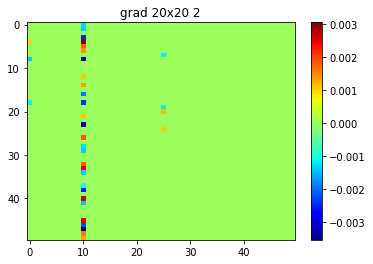

number of nonzero  tensor(6091)


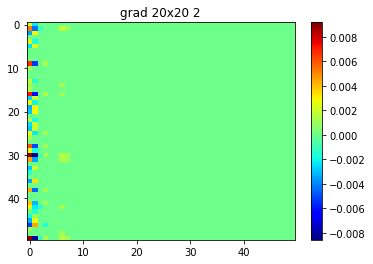

number of nonzero  tensor(1072)


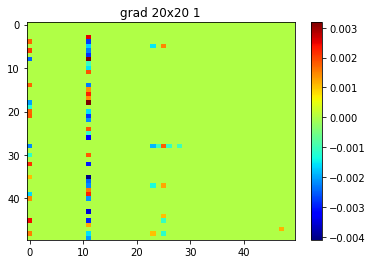

number of nonzero  tensor(6066)


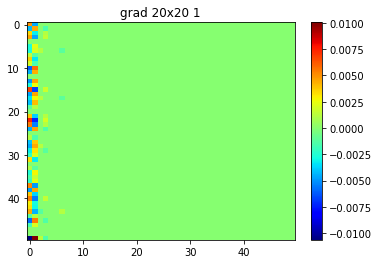

number of nonzero  tensor(2021)


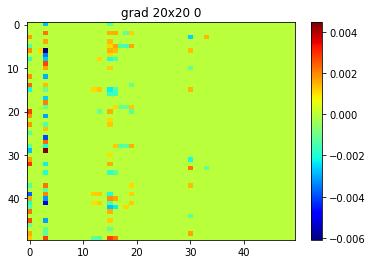

number of nonzero  tensor(5203)


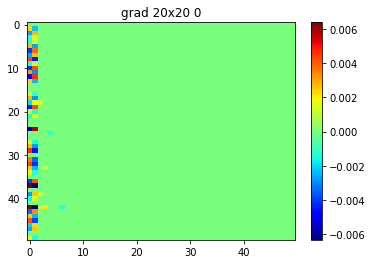

Step,Training Loss,Validation Loss,Matthews Correlation,Combined Score
100,No log,0.486645,0.465264,0.465264
200,No log,0.465752,0.473933,0.473933
300,No log,0.434411,0.529145,0.529145
400,No log,0.432065,0.510582,0.510582
500,0.479700,0.417453,0.549474,0.549474


finishing collecting gradients


In [150]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

In [152]:
trainer.evaluate()

{'eval_loss': 0.42497676610946655,
 'eval_matthews_correlation': 0.5447384394358111,
 'eval_combined_score': 0.5447384394358111,
 'eval_runtime': 3.1975,
 'eval_samples_per_second': 326.191,
 'eval_steps_per_second': 2.815,
 'epoch': 1.0,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 20480,
 'eval_mem_gpu_peaked_delta': 654792192}

In [114]:
import pickle
d = pickle.load( open( "/notebook/compression/exps/cola_pickles/bert_eval.pkl", "rb" ) )

In [112]:
e = pickle.load( open( "/notebook/compression/exps/cola_pickles/bert_eval_sp.pkl", "rb" ) ) 

In [165]:
len(eval_losses)

6

In [161]:
eval_losses.append(0.4231)

In [166]:
eval_losses

[0.4866446852684021,
 0.4657522141933441,
 0.43441125750541687,
 0.43206483125686646,
 0.4174531102180481,
 0.42497676610946655]

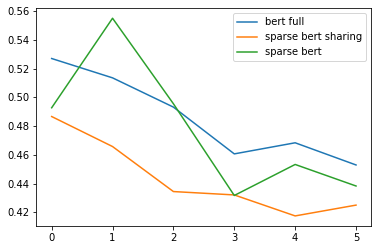

In [167]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(d), label = "bert full")
plt.plot(np.array(eval_losses), label = "sparse bert sharing")
plt.plot(np.array(e), label = "sparse bert")
plt.legend()

AttributeError: 'Trainer' object has no attribute 'losses'

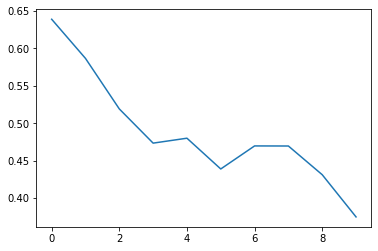

In [107]:
import matplotlib.pyplot as plt
import numpy as np

import pickle
d = pickle.load( open( "/notebook/compression/exps/cola_pickles/bert.pkl", "rb" ) ) 

plt.plot(np.mean(np.array(d)[:500].reshape(-1, 50), axis=1), label = "bert full")
plt.plot(np.mean(np.array(trainer.losses)[:500].reshape(-1, 50), axis=1), label = "sparse bert")
plt.legend()

In [ ]:
/notebook/compression/exps

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.mean(np.array(d)[:500].reshape(-1, 50), axis=1), label = "bert full")
plt.plot(np.mean(np.array(trainer.losses)[:500].reshape(-1, 50), axis=1), label = "sparse bert")
plt.legend()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/notebook/compression/exps/sharing


In [164]:
eval_losses = [elem['eval_loss'] for elem in trainer.state.log_history if 'eval_loss' in elem.keys()]
import pickle
with open('/notebook/compression/exps/cola_pickles/bert_eval_sp_001.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

In [ ]:
#train_result = trainer.train()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.mean(np.array(d)[:500].reshape(-1, 50), axis=1), label = "bert full")
plt.plot(np.mean(np.array(trainer.losses)[:500].reshape(-1, 50), axis=1), label = "sparse bert")
plt.legend()

In [ ]:
trainer.evaluate()

In [33]:
trainer.log_metrics("train", train_result.metrics)

***** train metrics *****
  before_init_mem_cpu        =     6089MB
  before_init_mem_gpu        =     9326MB
  epoch                      =        1.0
  init_mem_cpu_alloc_delta   =        0MB
  init_mem_cpu_peaked_delta  =        0MB
  init_mem_gpu_alloc_delta   =        0MB
  init_mem_gpu_peaked_delta  =        0MB
  total_flos                 =   523836GF
  train_loss                 =     0.4577
  train_mem_cpu_alloc_delta  =        2MB
  train_mem_cpu_peaked_delta =        0MB
  train_mem_gpu_alloc_delta  =      838MB
  train_mem_gpu_peaked_delta =     1741MB
  train_runtime              = 0:02:04.50
  train_samples_per_second   =      68.68
  train_steps_per_second     =      4.297


In [ ]:
class ProfCallback(TrainerCallback):
    def __init__(self, prof):
        self.prof = prof

    def on_step_end(self, args, state, control, **kwargs):
        self.prof.step()
